## Loading the Dataset

I will use the **Kaggle API** to download the raw dataset from Kaggle, then I will subset the data for analysis.

In [1]:
import os
import kaggle
import pandas as pd
import numpy as np

In [2]:
local_files = os.listdir()

# Check if dataset already exists in local files
if 'avocado-updated-2020.csv' not in local_files:
    
    if 'avocado-prices-2020.zip' not in local_files:
        api = kaggle.KaggleApi()
        api.authenticate()
        api.dataset_download_cli('timmate/avocado-prices-2020')
    
    dataset = "avocado-prices-2020.zip"

else:

    dataset = "avocado-updated-2020.csv"

usecols = ['date', 'year', 'average_price', 'type', 'geography', 'total_volume']
avocados = pd.read_csv(dataset, usecols=usecols)
avocados.head(5)

,date,average_price,total_volume,type,year,geography
0,2015-01-04,1.22,40873.28,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,organic,2015,Albany
2,2015-01-04,1.00,435021.49,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,conventional,2015,Baltimore/Washington


## Preliminary Analysis

Before I use KNN, I want to determine the appropriate approach. Specifically:
- What am I asking? What is the **target feature** I will be predicting?
- What is the **relevant data** in predicting the target class labels?

I will start by slimming down the dataset by *narrowing my focus to certain portions of the nominal features*: `type` and `geography`. A quick look at the data set reveals that there are two types of avocados: **conventional** and **organic**.

In [3]:
avocados['type'].unique()

array(['conventional', 'organic'], dtype=object)

I will compute the **average price per type** of avocado to see which one is more expensive on average.

In [4]:
# Create subsets of the data for each type
con_avos = avocados[avocados["type"] == "conventional"]
org_avos = avocados[avocados["type"] == "organic"]

# Isolate "average_price" column for each type subset
con_avos_avg_price = con_avos["average_price"]
org_avos_avg_price = org_avos["average_price"]

# Calculate and output the average of all average prices per type subset
print(f'Average price of conventional avocados: ${con_avos_avg_price.mean():.2f}')
print(f'Average price of organic avocados: ${org_avos_avg_price.mean():.2f}')

Average price of conventional avocados: $1.14
Average price of organic avocados: $1.62


I think it's interesting that organic avocados are more expensive, so I will focus on those. Now I want to narrow down `geography`, maybe to just a couple major cities. Specifically, I will **analyze the sales of organic avocados in LA and Chicago**.

In [5]:
# Create geographical subsets of the organic avocados subset
la_org_avos = org_avos[org_avos["geography"] == "Los Angeles"]
chi_org_avos = org_avos[org_avos["geography"] == "Chicago"]

# Combine the two geographical subsets and reset the index
la_chi_org_avos = pd.concat([la_org_avos, chi_org_avos])
la_chi_org_avos = la_chi_org_avos.reset_index().drop("index", axis=1)
la_chi_org_avos

,date,average_price,total_volume,type,year,geography
0,2015-01-04,1.25,54495.54,organic,2015,Los Angeles
1,2015-01-11,1.08,60232.63,organic,2015,Los Angeles
2,2015-01-18,1.29,43649.12,organic,2015,Los Angeles
3,2015-01-25,1.23,38078.07,organic,2015,Los Angeles
4,2015-02-01,1.12,50107.32,organic,2015,Los Angeles
...,...,...,...,...,...,...
607,2020-11-01,1.22,116028.80,organic,2020,Chicago
608,2020-11-08,1.25,104065.56,organic,2020,Chicago
609,2020-11-15,1.57,67443.21,organic,2020,Chicago
610,2020-11-22,1.71,49681.65,organic,2020,Chicago


Okay, so I've slimmed the dataset down from 33,045 samples to 612 samples by narrowing my focus to *organic avocado* sales in *LA and Chicago*. Now I will plot **average price** and **total volume** to preview the variation in these two numerical features.

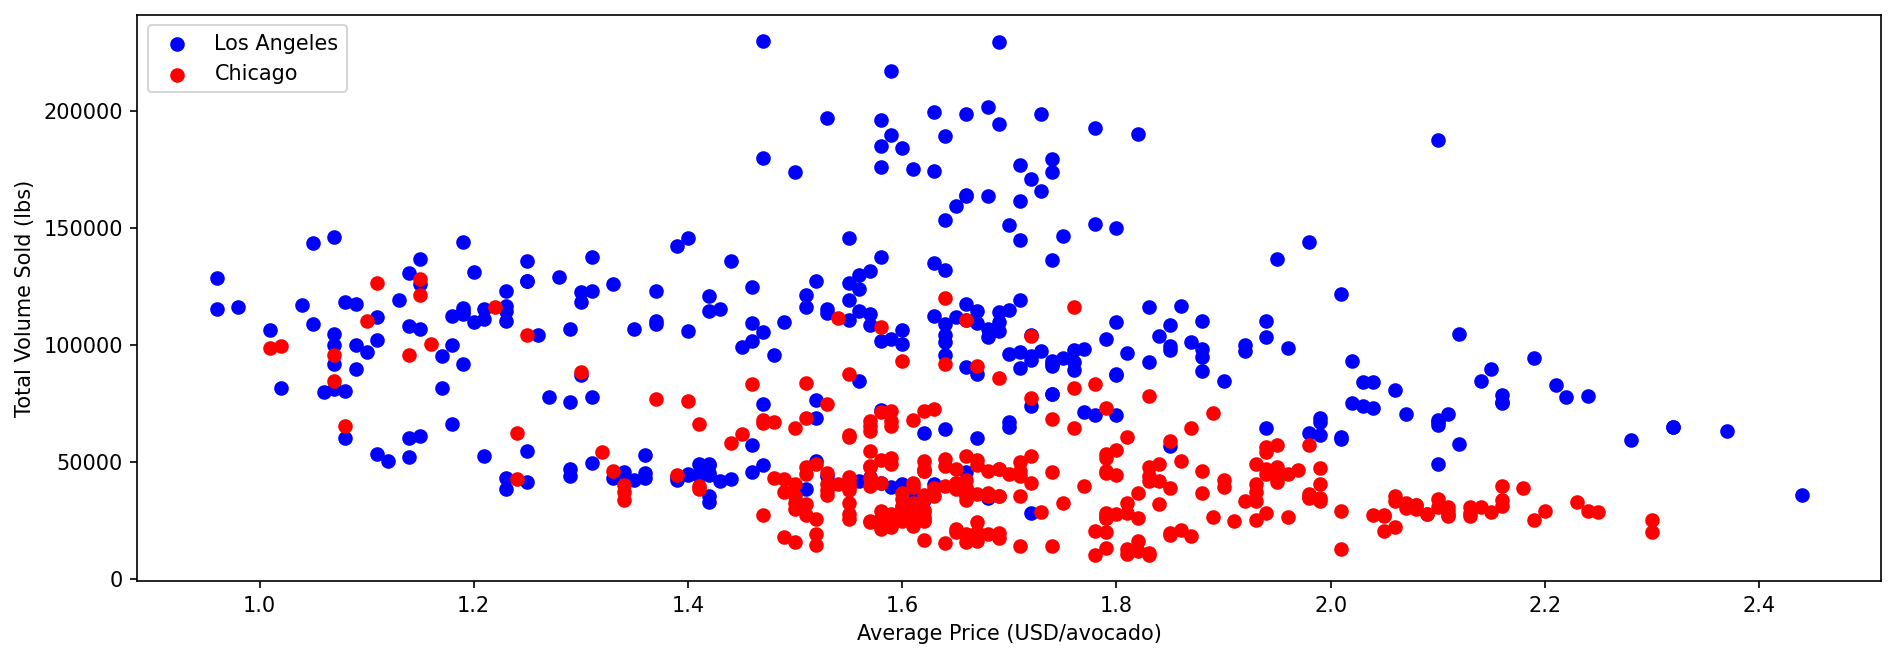

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define x- and y- axes
x = la_chi_org_avos["average_price"]
y = la_chi_org_avos["total_volume"]

# LA axes
x_la = x[la_chi_org_avos["geography"] == "Los Angeles"]
y_la = y[la_chi_org_avos["geography"] == "Los Angeles"]

# Chicago axes
x_chi = x[la_chi_org_avos["geography"] == "Chicago"]
y_chi = y[la_chi_org_avos["geography"] == "Chicago"]

# Plot the data
plt.figure(figsize=(15, 5), dpi=150)
plt.scatter(x_la,  y_la,  c='b', label='Los Angeles')
plt.scatter(x_chi, y_chi, c='r', label='Chicago')

# Decorate the plot
plt.xlabel('Average Price (USD/avocado)')
plt.ylabel('Total Volume Sold (lbs)')
plt.legend(loc='upper left')
plt.show()

## Dataset Preparation

After running preliminary analysis on the dataset, I've determined that my approach will be to use the KNN algorithm to **predict the location of a weekly avocado sales report based on the total volume sold and the average avocado price**. To simplify the problem, I will maintain the focus to only studying the organic avocados sales in LA and Chicago.

Here, I will separate the numerical features from the target feature, and I will split the data for training and testing.

In [7]:
from sklearn.model_selection import train_test_split

features = ["total_volume", "average_price"]
target = "geography"

X = la_chi_org_avos[features].to_numpy()
y = la_chi_org_avos[target].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

## Model Tuning

Now, I want to find the optimal number of neighbors, K, to answer my question ("optimal" being defined here as "most accurate on unseen data"). I will start by studying the performance of KNN at the two extremes of K.

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

clf_1 = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)
clf_x = KNeighborsClassifier(n_neighbors=len(X_train)).fit(X_train, y_train)

clf_1_preds = clf_1.predict(X_test)
clf_x_preds = clf_x.predict(X_test)

clf_1_acc = accuracy_score(y_test, clf_1_preds)
clf_x_acc = accuracy_score(y_test, clf_x_preds)

print("Accuracy when k=1:\n", clf_1_acc, "\n")
print("Accuracy when k=len(X_train):\n", clf_x_acc)

Accuracy when k=1:
 0.6829268292682927 

Accuracy when k=len(X_train):
 0.4796747967479675


After assessing the extremes of K, it seems that the model with `k=1` **underfits**, and the model with `k=len(X_train)` **overfits**.

When the model underfits to the training data, it has too much bias and too little variance. In contrast, when the model overfits to the training data, it has too little bias and too much variance.

Neither are beneficial to the prediction accuracy of a classification model, so I will now proceed to find some foretold "**sweet spot**" for K.

**Cross-validation** will help me to compare the performance across models with different values of K.

In [9]:
from sklearn.model_selection import cross_val_score

k_values = range(1, int(len(X_train)*0.9), 5)

max_per_k_value = []

for k in k_values:
    
    clf = KNeighborsClassifier(n_neighbors=k)
    cvs = cross_val_score(clf, X_train, y_train, cv=10)
    
    # Record each K with its best accuracy score from 10-fold cross-validation 
    per_k_value = [k, np.max(cvs)]
    max_per_k_value.append(per_k_value)
    
max_values = np.array(max_per_k_value)
    
print(f"Optimal K based on 10-fold cross-validation: {max_values[max_values.argmax(axis=0)[1]][0]:.0f}")

Optimal K based on 10-fold cross-validation: 26


I've calculated what seems to be the optimal value for K, but I want to graph all K values and their respective performances, just to see *how optimal* it is, if at all.

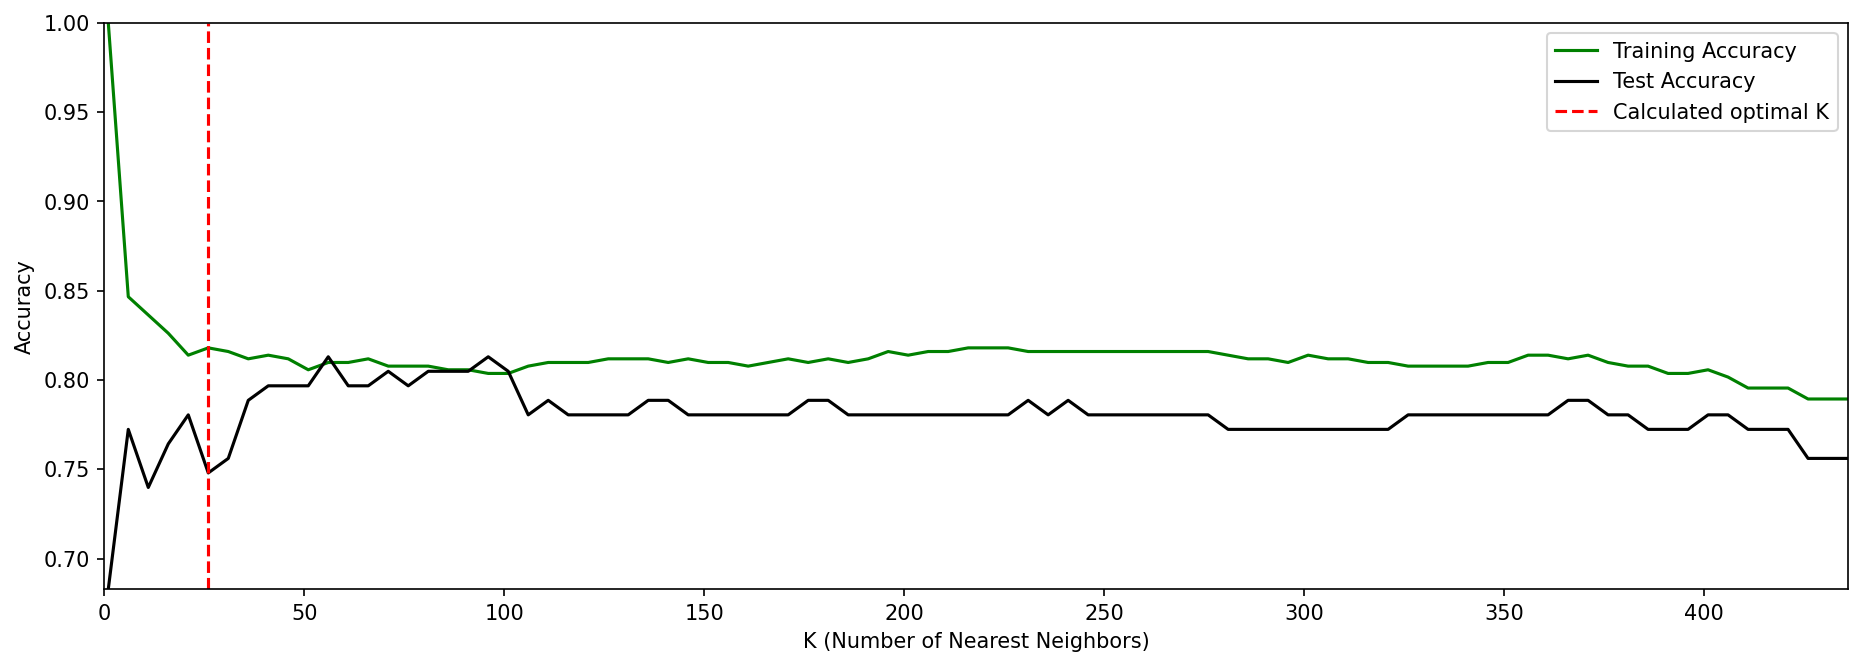

In [10]:
training_acc = []
test_acc = []

for k in k_values:
    clf = KNeighborsClassifier(k).fit(X_train, y_train)
    training_acc.append(clf.score(X_train, y_train))
    test_acc.append(clf.score(X_test, y_test))
    
# Plot the data
plt.figure(figsize=(15, 5), dpi=150)
plt.plot(k_values, training_acc,  c='g', label='Training Accuracy')
plt.plot(k_values, test_acc, c='0', label='Test Accuracy')
plt.vlines(26, np.min(test_acc), 1, linestyles='dashed', color='red', label='Calculated optimal K')

# Decorate the plot
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

plt.xlim(0, np.max(k_values))
plt.ylim(np.min(test_acc), 1)
plt.show()

Judging by the graph, I notice that the `k=1` model clearly underfits and that the model with the highest K has the lowest accuracy from overfitting. This matches our earlier analysis of the extreme values of K.

I also notice that although the calculated optimum of `k=26` seems to have a peak accuracy (albeit a very slight difference from the rest) on the *training set*, the optimal K value on the *test set* was actually somewhere between `k=50` and `k=100`.

**Objective Met:** I was able to determine an optimal value of K through cross-validation, specifically by iterating over a range of K values to find which one produced the highest accuracy score, but its performance was *judged solely on predictions made on the training set*. In actuality, **visualizing the cross-validation scores** helped to understand how an optimal K value may differ from the training set to the test set, so I should be more thorough in calculating an optimum. Specifically, I can maybe use different metrics other than accuracy, such as F1 score or 